# Ticket inspection AI

## Config

In [1]:
IS_WINDOWS = False
SAVE_AS_BEST = False
OLD_LINJE_TO_NEW = True

# Trials
TWO_TRIALS = 750
FOUR_TRIALS = 2_000

## Imports

In [2]:
import optuna as opt
import os
import pandas as pd
from sdv.evaluation import evaluate
from sdv.tabular import GaussianCopula
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Functions

In [3]:
from utils.utils import *

### Functions for running recursion on lines

In [4]:
from utils.recursive_utils import *

# Reading data

In [5]:
if IS_WINDOWS:
    db_main = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx')
    db_aanerud = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx')
else:
    db_main = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx")
    db_aanerud = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx")

db_aanerud.head(3)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,R14,Fremst,2023-01-21,16:54:00,Skarnes,Oslo s,Nei,Nei,NaN
1,R14,NaN,2023-01-22,17:04:00,Oslo s,Kongsvinger,Nei,Ja,Ble sjekket med en gang toget reiste
2,R14,4,2023-01-27,16:32:00,Oslo s,Årnes,Nei,Nei,NaN


In [6]:
db = pd.concat([db_main, db_aanerud])
db.tail(2)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
12,R14,5,2023-05-04,14:04:00,Oslo s,Skarnes,Nei,Nei,NaN
13,R14,Fremst,2023-05-10,16:32:00,Oslo s,Skarnes,Nei,Nei,NaN


In [7]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 13
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     168 non-null    object        
 1   Vogn      164 non-null    object        
 2   Dato      168 non-null    datetime64[ns]
 3   Klokke    168 non-null    object        
 4   Fra       168 non-null    object        
 5   Til       168 non-null    object        
 6   Fullt?    168 non-null    object        
 7   Sjekket?  168 non-null    object        
 8   Merknad   65 non-null     object        
dtypes: datetime64[ns](1), object(8)
memory usage: 13.1+ KB


# Data cleaning and engineering

## Categorize the features

In [8]:
db = db.fillna(-1)

Converts old lines to new if configured

In [9]:
db["Linje"] = db["Linje"].apply(lambda x: strCleaner(x))

# Converts old lines to new
if OLD_LINJE_TO_NEW:
    db["Linje"] = db["Linje"].apply(lambda x: convert_linje_to_new(x))

Extract date sub-categories

In [10]:
db["Dag"] = db["Dato"].apply(lambda x: extractDay(x))
db["Måned"] = db["Dato"].apply(lambda x: extractMonth(x))
# db["År"] = db["Dato"].apply(lambda x: extractYear(x)) # Not relevant for the timescale I have

db = db.drop("Dato", axis=1)
db.head(3)

,Linje,Vogn,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned
0,r12,Fremst,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,-1,25,9
1,re10,Bakerst,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,-1,25,9
2,r12,Fremst,09:30:00,Eidsvoll,Nationaltheatret,Ja,Nei,-1,26,9


Exctract time sub-categories

In [11]:
db["Time"] = db["Klokke"].apply(lambda x: extractHour(x))
db["Minutt"] = db["Klokke"].apply(lambda x: extractMinute(x))

db = db.drop("Klokke", axis=1)
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,r12,Fremst,Eidsvoll,Oslo Lufthavn,Nei,Nei,-1,25,9,11,30
1,re10,Bakerst,Oslo Lufthavn,Eidsvoll,Ja,Ja,-1,25,9,21,59
2,r12,Fremst,Eidsvoll,Nationaltheatret,Ja,Nei,-1,26,9,9,30


### Cleaning all strings

In [12]:
db["Fullt?"] = db["Fullt?"].apply(lambda x: strCleaner(x))
db["Sjekket?"] = db["Sjekket?"].apply(lambda x: strCleaner(x))
db["Fra"] = db["Fra"].apply(lambda x: strCleaner(x))
db["Til"] = db["Til"].apply(lambda x: strCleaner(x))

In [13]:
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,r12,Fremst,eidsvoll,oslo_lufthavn,nei,nei,-1,25,9,11,30
1,re10,Bakerst,oslo_lufthavn,eidsvoll,ja,ja,-1,25,9,21,59
2,r12,Fremst,eidsvoll,nationaltheatret,ja,nei,-1,26,9,9,30


### Recursive lines for optimizing the data

In [14]:
db = handle_recursion(db)
db.to_excel("/Users/sigurdskyrud/Desktop/recursive_db.xlsx", index=False)

Merknad needs to convert all empty values to -1

In [15]:
db["Merknad"].fillna(-1)

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
1883    -1
1884    -1
1885    -1
1886    -1
1887    -1
Name: Merknad, Length: 1888, dtype: object

## Converting all strings to numbers and floats

In [16]:
fulltCat = pd.Categorical(db["Fullt?"])
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes


sjekketCat = pd.Categorical(db["Sjekket?"])
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes


fraCat = pd.Categorical(db["Fra"])
db["Fra"] = pd.Categorical(db["Fra"]).codes


tilCat = pd.Categorical(db["Til"])
db["Til"] = pd.Categorical(db["Til"]).codes

linjeCat = pd.Categorical(db["Linje"])
db["Linje"] = pd.Categorical(db["Linje"]).codes

Vogn needs to be converted to a string

In [17]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: strCleaner(x))

vognCat = pd.Categorical(db["Vogn"])
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

Merknad to int

In [18]:
merknadCat = pd.Categorical(db["Merknad"])
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

### Check that categories are correct

In [19]:
print(linjeCat.categories)
print(fraCat.categories)
print(tilCat.categories)
print(fulltCat.categories)
print(sjekketCat.categories)

Index(['l1', 'l2', 'r12', 'r13', 'r14', 're10', 're11'], dtype='object')
Index(['auli', 'blaker', 'eidsvoll', 'eidsvoll_verk', 'fetsund', 'haga',
       'lillestrøm', 'lørenskog', 'nationaltheatret', 'nerdrum',
       'oslo_lufthavn', 'oslo_s', 'rånåsfoss', 'skarnes', 'svingen',
       'sørumsand', 'årnes'],
      dtype='object')
Index(['auli', 'blaker', 'eidsvoll', 'eidsvoll_verk', 'fetsund', 'haga',
       'hamar', 'jessheim', 'kongsvinger', 'lillestrøm', 'nationaltheatret',
       'nerdrum', 'oslo_lufthavn', 'oslo_s', 'rånåsfoss', 'skarnes', 'stange',
       'svingen', 'sørumsand', 'tangen', 'årnes'],
      dtype='object')
Index(['ja', 'nei', 'noe'], dtype='object')
Index(['ja', 'nei'], dtype='object')


### Running recursion on lines that support it for optimization of data

In [20]:
# Vogn is just noise
db = db.drop("Vogn", axis=1)
db = db.drop("Merknad", axis=1)

In [21]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Linje     1888 non-null   int8 
 1   Fra       1888 non-null   int8 
 2   Til       1888 non-null   int8 
 3   Fullt?    1888 non-null   int8 
 4   Sjekket?  1888 non-null   int8 
 5   Dag       1888 non-null   int64
 6   Måned     1888 non-null   int64
 7   Time      1888 non-null   int64
 8   Minutt    1888 non-null   int64
dtypes: int64(4), int8(5)
memory usage: 68.3 KB


<AxesSubplot: >

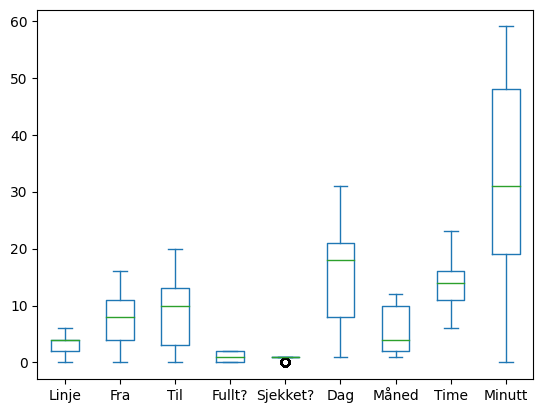

In [22]:
db.plot.box()

# Synthetic data

### SDV

In [23]:
# sdv = GaussianCopula()
# sdv.fit(db)
# sample = sdv.sample(500)
# sample.head(3)

In [24]:
# Dont work
#evaluate(sample, db, metrics=['CSTest'], aggregate=False)

In [25]:
# db = pd.concat([db, sample])

# Creating testing data

In [26]:
# Create the data to create predict from
X = db.drop(["Sjekket?"], axis=1)

# Create the data to predict to
y = db["Sjekket?"]

### Testing without clock
# X = X.drop(["Klokke"], axis=1)

X.head(3)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,5,2,13,2,13,1,8,11
1,2,11,2,2,13,1,11,54
2,2,11,3,2,13,1,11,54


# Train_test_split

In [27]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating model1 - XGBoostClassifier

In [28]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
preds = model.predict(X_test)

## Model 1 testing

### Model 1's confusion matrix

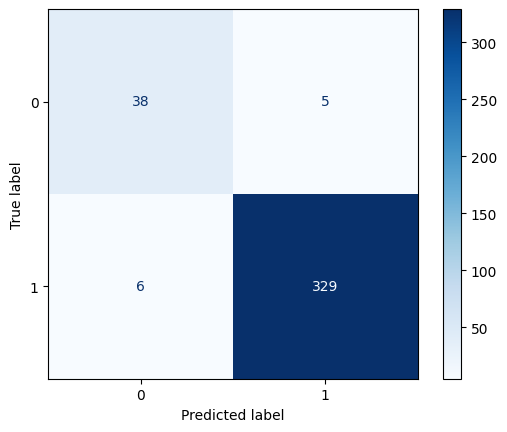

In [30]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

In [31]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
print(f"Accuracy: {accuracy * 100.0 :.2f}")

Accuracy: 97.09


### Model 1's feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

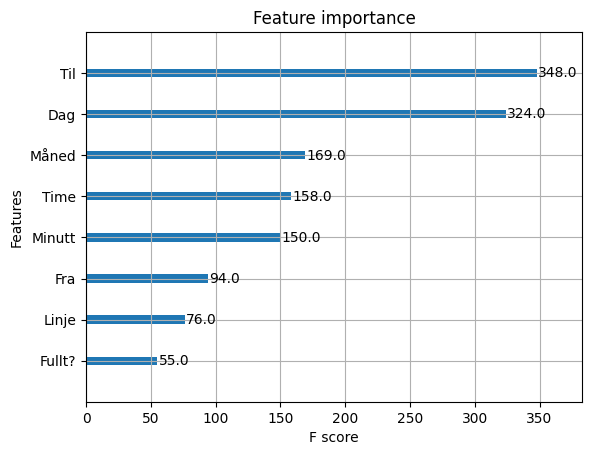

In [32]:
xgb.plot_importance(model)

# Creating model 2 - Model 1 with optuna

In [33]:
def objective(trial):
    """The objective is to find the best parameters for the most accuracy in the model"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1e+3),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss'
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=TWO_TRIALS)

[I 2023-05-22 12:57:21,594] A new study created in memory with name: no-name-3136a663-a7f2-4b6d-be37-d8235577f757
[I 2023-05-22 12:57:21,822] Trial 0 finished with value: 0.8862433862433863 and parameters: {'max_depth': 6, 'learning_rate': 0.4557854942286837, 'n_estimators': 451, 'min_child_weight': 4, 'gamma': 992.742923440854, 'subsample': 0.08658223415914965, 'colsample_bytree': 0.17722410694144153, 'reg_alpha': 0.9289377220698568, 'reg_lambda': 0.9620435628391147}. Best is trial 0 with value: 0.8862433862433863.
[I 2023-05-22 12:57:21,921] Trial 1 finished with value: 0.8862433862433863 and parameters: {'max_depth': 5, 'learning_rate': 0.14968940519595483, 'n_estimators': 178, 'min_child_weight': 0, 'gamma': 620.1443534078484, 'subsample': 0.2121367344369943, 'colsample_bytree': 0.1527670067860613, 'reg_alpha': 0.1472554295747646, 'reg_lambda': 0.41383541201355317}. Best is trial 0 with value: 0.8862433862433863.
[I 2023-05-22 12:57:22,092] Trial 2 finished with value: 0.8862433862

In [34]:
bparams = study.best_params
model2 = xgb.XGBClassifier(**bparams)
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6948886802444475, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.004117623870393328, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6982935376007698, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=299, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
preds2 = model2.predict(X_test)

## Model 2 testing

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

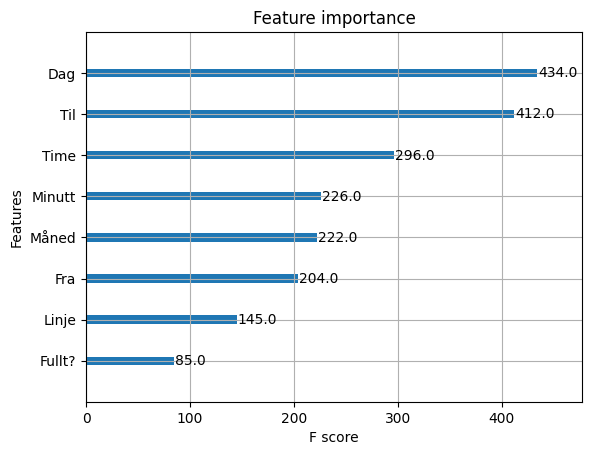

In [36]:
xgb.plot_importance(model2)

### Model 2 Confusion Matrix

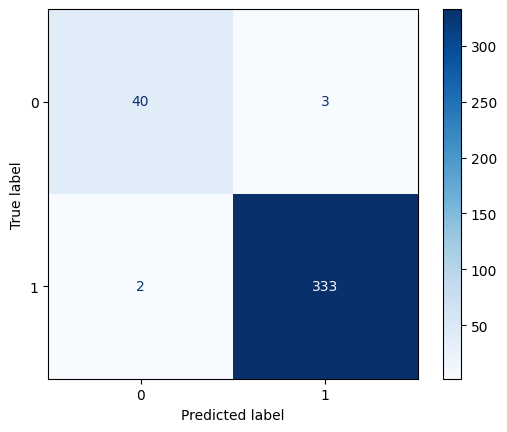

In [37]:
cm = confusion_matrix(y_true=y_test, y_pred=preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

In [38]:
accuracy2 = accuracy_score(y_true=y_test, y_pred=preds2)
print(f"Accuracy: {accuracy2 * 100.0 :.2f}")

Accuracy: 98.68


# Model 3 - Logistic regression

In [39]:
model3 = LogisticRegression(solver='liblinear', random_state=42)
model3.fit(X_train, y_train)
preds3 = model3.predict(X_test)


## Model 3 testing

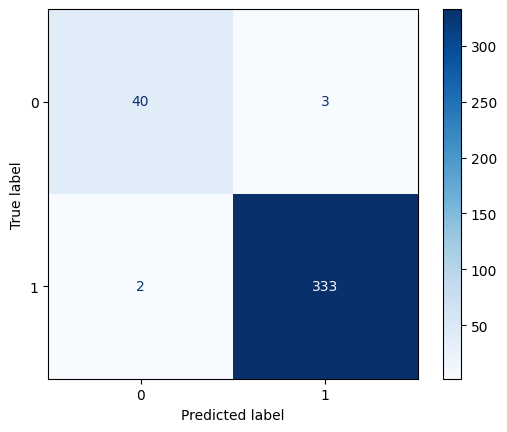

In [40]:
cm = confusion_matrix(y_true=y_test, y_pred=preds3)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)

disp.plot(cmap='Blues')

In [41]:
print(model3.score(X_test, y_test))
accuracy3 = accuracy_score(y_true=y_test, y_pred=preds3)
print(f"Accuracy: {accuracy3 * 100.0 :.2f}")

0.91005291005291
Accuracy: 91.01


In [42]:
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.68      0.40      0.50        43
           1       0.93      0.98      0.95       335

    accuracy                           0.91       378
   macro avg       0.80      0.69      0.73       378
weighted avg       0.90      0.91      0.90       378



# Model 4 - Logistic regression with optuna

In [43]:
heyho = {'hello': 'hi'}

if 'hello' in heyho:
    index = list(heyho.values())[0]

print(index)

hi


In [44]:
def check_value_exist(dict: dict, liste: list) -> bool:
    do_exist = False
    for l in liste:
            for key, val in dict.items():
                if val == l:
                    do_exist = True
    return do_exist

In [45]:
def objective(trial):
    """
    Tests parameters for sciKit LogicalRegression
    """


    # Cant use suggest_categorical for multiple strings. Crashes
    # Tried with setting string values from random list number, dont work
    # CANT ACTUALLY SET STRING VALUES WIHTOUT USING CATEGORICAL, and that not workign with multiple
    # Solver
    # solver_num = random.randint(0, 4)
    # solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    solver = 'liblinear' # solver_list[solver_num]
    # fit_intercept
    # fit_num = trial.suggest_int('fit_num', 0, 1)

    params = {
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'C': trial.suggest_float('C', 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'random_state': trial.suggest_int('random_state', 0, 50),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0, 1.0),
        'solver': trial.suggest_categorical('solver', [solver]),
        'max_iter': trial.suggest_int('max_iter', 0, 60)
    }

    # Pentalty
    #if check_value_exist(params, ['newton-cg', 'lbfgs', 'sag']):
    #    number = random.randint(0, 1)
    #    if number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])})
    #elif check_value_exist(params, ['liblinear']):
    #number = random.randint(0, 1)
    #if number == 1:
    params.update({'penalty': trial.suggest_categorical('penalty', ["l1", "l2"])}) # l1 sucks with liblinear, dont use
    #else:
    #    params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #elif check_value_exist(params, ['saga']):
    #    number = random.randint(0, 3)
    #    if number == 0:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["elasticnet"])})
    #    elif number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    elif number == 2:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l1"])})  
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])}) 

    # l1_ratio //sucks balls man
    if check_value_exist(params, ['l1', 'elasticnet']):
        params.update({'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0)})

    # Dual
    if check_value_exist(params, ['l2']) and check_value_exist(params, ['liblinear']):
        params.update({'dual': trial.suggest_categorical('dual', [True, False])})
    #else:
    #    params.update({'dual': trial.suggest_categorical('dual', [False])})

    # Fit the model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=FOUR_TRIALS)

[I 2023-05-22 12:59:43,698] A new study created in memory with name: no-name-bc5c539f-5a72-4beb-be69-0a098dc021ab
/opt/miniconda3/envs/billettkontroll3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-05-22 12:59:43,708] Trial 0 finished with value: 0.9021164021164021 and parameters: {'tol': 0.03257660482637389, 'C': 0.14789848504435388, 'fit_intercept': True, 'random_state': 12, 'intercept_scaling': 0.4811878573738445, 'solver': 'liblinear', 'max_iter': 4, 'penalty': 'l2', 'dual': True}. Best is trial 0 with value: 0.9021164021164021.
/opt/miniconda3/envs/billettkontroll3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-05-22 12:59:43,713] Trial 1 finished with value: 0.91005291005291 and parameters: {'tol': 0.06612525862188653, 'C': 0.8296094794701

In [46]:
bparams = study.best_params
model4 = LogisticRegression(**bparams)
model4.fit(X_train, y_train)
preds4 = model4.predict(X_test)
bparams

/opt/miniconda3/envs/billettkontroll3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'tol': 0.09717953195515443,
 'C': 0.8670528973348471,
 'fit_intercept': False,
 'random_state': 18,
 'intercept_scaling': 0.804811630727245,
 'solver': 'liblinear',
 'max_iter': 49,
 'penalty': 'l2',
 'dual': True}

## Model 4 testing

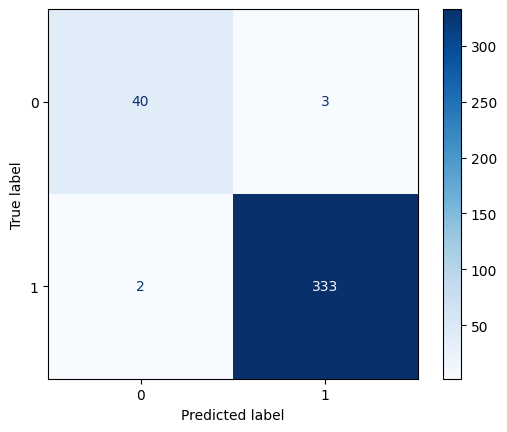

In [47]:
cm = confusion_matrix(y_true=y_test, y_pred=preds4)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)

disp.plot(cmap='Blues')

In [48]:
print(model4.score(X_test, y_test))
accuracy4 = accuracy_score(y_true=y_test, y_pred=preds4)
print(f"Accuracy: {accuracy4 * 100.0 :.2f}")

0.9365079365079365
Accuracy: 93.65


# Best

In [49]:
accuracies = [accuracy, accuracy2, accuracy3, accuracy4]

counter = 1
best_a = 0
for a in accuracies:
    if a > best_a:
        best = counter
        best_a = a
    
    counter = counter+1

print(f"Best is model number {best} with the score: {best_a * 100 :.2f}")

Best is model number 2 with the score: 98.68


In [50]:
import json
from datetime import datetime
import pytz
import pickle as pk

In [51]:
utc = pytz.utc


if best == 1:
    bmodel = model
elif best == 2:
    bmodel = model2
elif best == 3:
    bmodel = model3
else:
    bmodel = model4

try:
    bmodel.save_model("../models/model.h5")
except:
    print("Can't save to H5 format.")

pk.dump(bmodel, open('../models/model.pkl', 'wb'))
pk.dump(best_a, open('../accuracy/accuracy.pkl', 'wb'))

with open("../models/dates.json", "r+") as f:
    data = json.load(f)

with open("../models/dates.json", "w") as f:
    date = datetime.now(utc)
    data["newest_model"] = {"day": date.day, "month": date.month, "year": date.year}
    json.dump(data, f)

If this runs best model is better than altime best model, replace with this

In [52]:
if SAVE_AS_BEST:
    pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
    pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))

    print(f"This rounds best model with {best_a * 100 :.2f}% was saved as alltime best due to config.")
else:
    best_best_a = pk.load(open('../accuracy/best_accuracy.pkl', 'rb'))

    if best_a > best_best_a:
        pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
        pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))
        best_best_a = best_a

    print(f"Best: {best_a} Best_best: {best_best_a}")

with open("../models/dates.json", "r+") as f:
    data = json.load(f)

with open("../models/dates.json", "w") as f:
    date = datetime.now(utc)
    data["best_model"] = {"day": date.day, "month": date.month, "year": date.year}
    json.dump(data, f)

Best: 0.9867724867724867 Best_best: 0.9867724867724867


In [53]:
pk.dump(X_test, open('../categories/X_test.pkl', 'wb'))

In [54]:
if SAVE_AS_BEST or best_a > best_best_a:
    pk.dump(linjeCat, open('../categories/linjeCat.pkl', 'wb'))
    pk.dump(vognCat, open('../categories/vognCat.pkl', 'wb'))
    pk.dump(fraCat, open('../categories/fraCat.pkl', 'wb'))
    pk.dump(tilCat, open('../categories/tilCat.pkl', 'wb'))
    pk.dump(fulltCat, open('../categories/fulltCat.pkl', 'wb'))
    pk.dump(sjekketCat, open('../categories/sjekketCat.pkl', 'wb'))

# Self testing

In [55]:
X_test.head(5)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
1185,4,13,18,1,15,5,11,52
1054,2,11,12,0,20,4,14,54
1743,4,6,13,1,18,11,14,59
1512,4,9,4,2,21,10,17,20
1460,4,14,4,1,21,10,13,47


In [56]:
y_test.head(5)

1185    1
1054    1
1743    1
1512    1
1460    1
Name: Sjekket?, dtype: int8

In [57]:
tester = X_test
tester = tester.drop(X_test.index)
tester

# Parameters
linje = "re11"
#vogn = "fremst"
fra = "nationaltheatret"
til = "eidsvoll"
fullt = "ja"
dag = 31
måned = 10
time = 14
minutt = 35

data = {"Linje": [findCatCode(linjeCat, linje)], 
          #"Vogn": [findCatCode(vognCat, vogn)],
          "Fra": [findCatCode(fraCat, fra)], 
          "Til": [findCatCode(tilCat, til)], 
         "Fullt?": [findCatCode(fulltCat, fullt)],
         "Dag": [dag],
         "Måned": [måned],
         "Time": [time],
         "Minutt": [minutt]}

testdb = pd.DataFrame(data)

tester = pd.concat([tester, testdb])
tester


,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,6,8,2,0,31,10,14,35


In [58]:
# Finds what the number means
ja = findCatCode(sjekketCat, 'ja')
nei = findCatCode(sjekketCat, 'nei')

print(f"{nei} = Nei\n"+
      f"{ja} = Ja")

testpred = bmodel.predict(tester)
print(f"Predicted: {testpred}")

if testpred[0] == ja:
    print("Ja, det er en sannsynlighet for å bli kontrollert")
else:
    print("Nei, det er liten sannsynlighet for å bli kontrollert")

1 = Nei
0 = Ja
Predicted: [0]
Ja, det er en sannsynlighet for å bli kontrollert


In [59]:
linjer = list(linjeCat.categories)
linjer

['l1', 'l2', 'r12', 'r13', 'r14', 're10', 're11']